# Quantum Monte Carlo for European Options Pricing

In [1]:
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
from qiskit.circuit.library import RYGate, GroverOperator, LinearAmplitudeFunction
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import circuit_drawer
import random
from qiskit.primitives import Sampler
from qiskit_finance.circuit.library.probability_distributions import NormalDistribution, LogNormalDistribution
from qiskit_algorithms import AmplitudeEstimation, EstimationProblem

Define parameters

In [2]:
S_0 = 100 # asset price at t=0 
sigma = 0.2 # volatility
K = 50 # strike price
r = 0.05 # risk-free interest rate
T = 1 # time to maturity in years

parameters = {'S_0': S_0,
              'sigma': sigma,
              'K': K,
              'r': r,
              'T': T
              }

Black-Scholes Formula

In [3]:
d_1 = (np.log(S_0/K)+(r+0.5*sigma**2)*T)/(sigma*T**0.5)
d_2 = (np.log(S_0/K)+(r-0.5*sigma**2)*T)/(sigma*T**0.5)

C_0 = S_0*norm.cdf(d_1)-math.exp(-r*T)*K*norm.cdf(d_2)
P_0 = math.exp(-r*T)*K*norm.cdf(-d_2)-S_0*norm.cdf(-d_1)

print(f'European Call: {C_0}')
print(f'European Put: {P_0}')

European Call: 52.438862117161854
European Put: 0.0003333421975565982


Standard Monte Carlo

In [4]:
def standard_MC(M, parameters, option_type):
    """
    Performs standard Monte Carlo estimation for option 
    pricing

    Parameters:
    M (int): Number of samples.
    parameters (dict): Dictionary containing option parameters.
    option_type (str): Type of the option, either 'call' or 'put'.

    Returns:
    float: discounted expected payoff
    """

    S_0 = parameters['S_0']
    r = parameters['r']
    sigma = parameters['sigma']
    T = parameters['T']
    K = parameters['K']

    if option_type == 'call':
        # samples 
        samples = [max(S_0*math.exp((r-sigma**2/2)*T+sigma*np.random.normal(0, T**0.5))-K,0) for _ in range(M)]
    
    elif option_type == 'put':
        samples = [max(K-S_0*math.exp((r-sigma**2/2)*T+sigma*np.random.normal(0, T**0.5)),0) for _ in range(M)]

    else:
        return -1

    # expected payoff
    expectation = sum(samples)/len(samples)

    # discounted payoff
    return math.exp(-r*T)*(expectation)

Run experiment with standard Monte Carlo

In [5]:
max_samples = 10 # the maximum number of samples is 2^max_samples
max_iterations = 10

results_standard_mc_call = []
results_standard_mc_put = []

for i in range(max_iterations):

    results_call = []
    results_put = []
    
    M_list = [2**(i+1) for i in range(max_samples)]

    for M in M_list:
        results_call.append(standard_MC(M, parameters, 'call'))
        results_put.append(standard_MC(M, parameters, 'put'))

    errors_call = [abs(res-C_0)/C_0 for res in results_call]
    errors_put = [abs(res-P_0)/P_0 for res in results_put]

    results_standard_mc_call.append([results_call, errors_call])
    results_standard_mc_put.append([results_put, errors_put])

In [11]:
def average(data):
    """
    Compute average of different iterations

    Parameters:
    data (list)
    """

    res = []
    for i in range(len(data[0])):
        temp = []
        for j in range(len(data)):
            temp.append(data[j][i])
        res.append(np.mean(temp))
    return res

def standard_deviation(data):
    """
    Compute standard deviation of different iterations

    Parameters:
    data (list)
    """
    res = []

    for i in range(len(data[0])):

        temp = []

        for j in range(len(data)):
            temp.append(data[j][i])
        res.append(np.std(temp))

    return res

def cf_interval(list_average, list_std, obs, level=1.96):
    """
    Compute confidence itervals

    Parameters:
    list_average (list)
    list_std (list)
    obs (int)
    level (float)

    """
    res = [[], []]
    for i in range(len(list_average)):
        res[0].append(list_average[i]-level*list_std[i]/obs**0.5)
        res[1].append(list_average[i]+level*list_std[i]/obs**0.5)
    return res


def polynomial_fit(x, y):
    """
    Compute the slope of iterations

    Parameters:
    x, y (list)
    """
    coef = np.polyfit(np.log2(np.array(x)), np.log10(np.array(y)), 1)
    return coef

Plot results

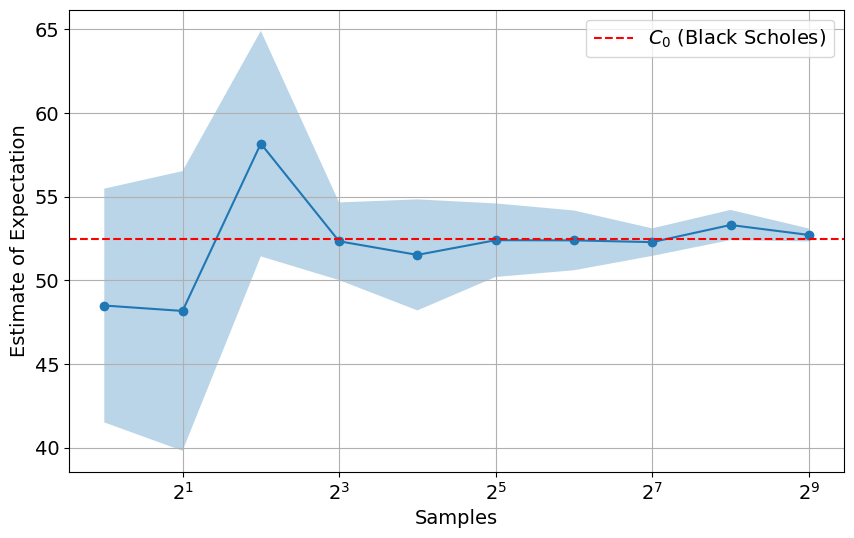

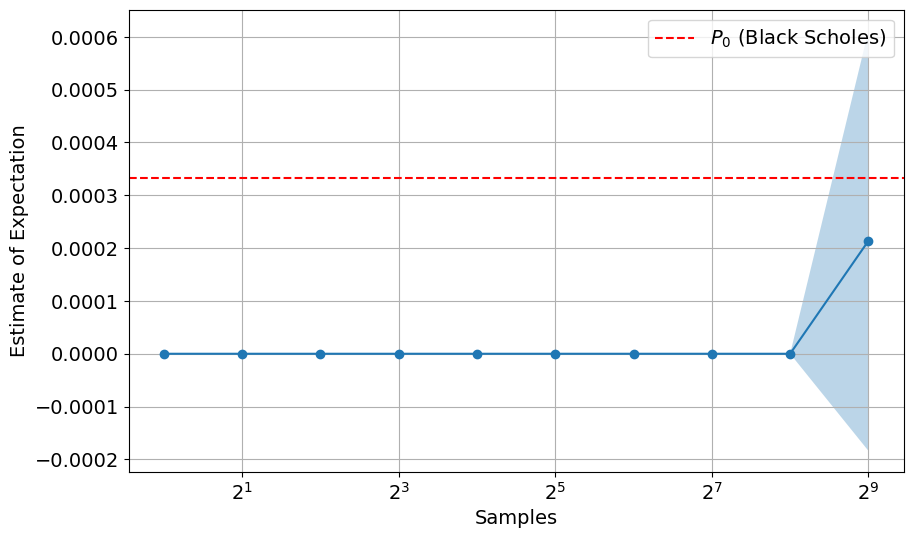

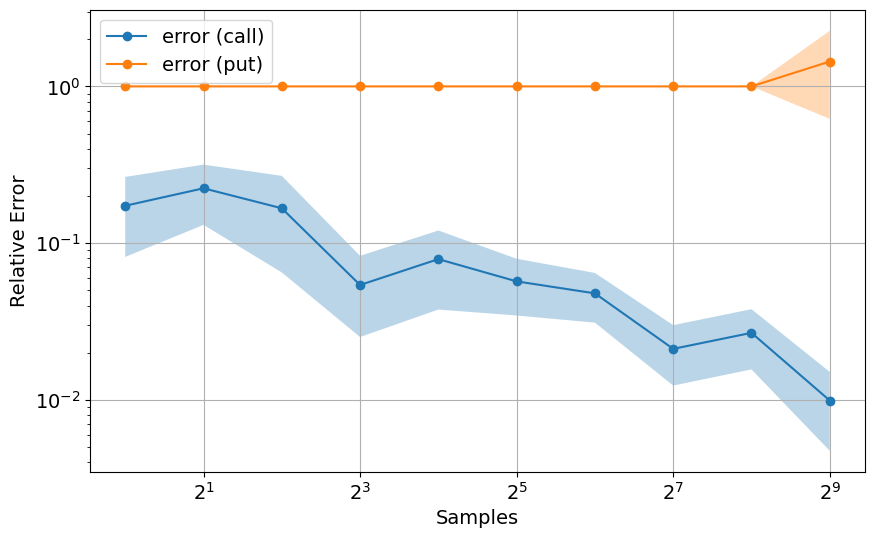

In [7]:
results_call = [results_standard_mc_call[i][0] for i in range(len(results_standard_mc_call))]
results_put = [results_standard_mc_put[i][0] for i in range(len(results_standard_mc_put))]
errors_call = [results_standard_mc_call[i][1] for i in range(len(results_standard_mc_call))]
errors_put = [results_standard_mc_put[i][1] for i in range(len(results_standard_mc_put))]

# plot results for call option
plt.figure(figsize=(10, 6))
x = [2**(i+1) for i in range(len(results_call[0]))]
y = average(results_call)
obs = len(results_call)
cfi = cf_interval(y, standard_deviation(results_call), obs)
plt.plot(x, y, marker='o', linestyle='-')
plt.fill_between(x, cfi[0], cfi[1], alpha=0.3)
plt.axhline(y=C_0, color='r', linestyle='--', label=r'$C_0$ (Black Scholes)')
plt.xscale('log', base=2)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Estimate of Expectation', fontsize=14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

# plot results for put option
plt.figure(figsize=(10, 6))
x = [2**(i+1) for i in range(len(results_put[0]))]
y = average(results_put)
obs = len(results_put)
cfi = cf_interval(y, standard_deviation(results_put), obs)
plt.plot(x, y, marker='o', linestyle='-')
plt.fill_between(x, cfi[0], cfi[1], alpha=0.3)
plt.axhline(y=P_0, color='r', linestyle='--', label=r'$P_0$ (Black Scholes)')
plt.xscale('log', base=2)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Estimate of Expectation', fontsize=14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

# plot results for call option
plt.figure(figsize=(10, 6))
x = [2**(i+1) for i in range(len(errors_call[0]))]
y = average(errors_call)
obs = len(errors_call)
cfi = cf_interval(y, standard_deviation(errors_call), obs)
plt.plot(x, y, marker='o', linestyle='-', label='error (call)')
plt.fill_between(x, cfi[0], cfi[1], alpha=0.3)

# plot results for put option
x = [2**(i+1) for i in range(len(errors_put[0]))]
y = average(errors_put)
obs = len(errors_put)
cfi = cf_interval(y, standard_deviation(errors_put), obs)
plt.plot(x, y, marker='o', linestyle='-', label='error (put)')
plt.fill_between(x, cfi[0], cfi[1], alpha=0.3)

plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Relative Error', fontsize=14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

Discretized probability space

In [6]:
n = 3 # number of bits to describe the probability space
mean = 0 # mean of standard Brownian motion
std = T**0.5 # standard deviation of standard Brownian motion


x = np.linspace(-4*std, 4*std, 1000)
y = [1/(std*(2*math.pi)**0.5)*math.exp(-1/2*((z-mean)/std)**2) for z in x]

# discrete
x_discretized = np.linspace(-3*std, 3*std, 2**n)
y_discretized = [1/(std*(2*math.pi)**0.5)*math.exp(-1/2*((z-mean)/std)**2) for z in x_discretized]
y_prob = [val/sum(y_discretized) for val in y_discretized]

Plot probability distribution

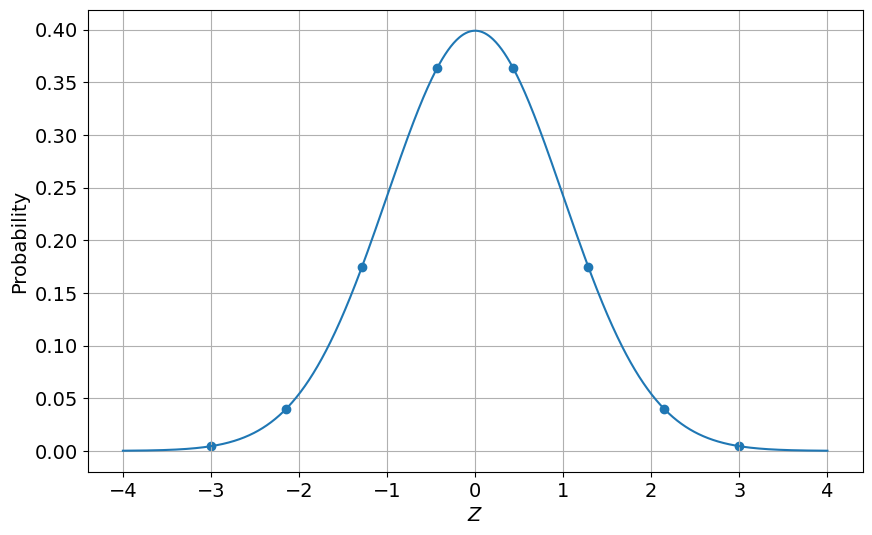

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, linestyle='-')
plt.scatter(x_discretized, y_discretized)
plt.xlabel(r'$Z$', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.show()

In [7]:
def discretized_standard_MC(M, parameters, option_type, x_discretized, y_prob):
    """
    Perform Monte Carlo estimation for option pricing 
    using a discretized approach.

    Parameters:
    M (int): Number of Monte Carlo samples.
    parameters (dict): Dictionary containing option parameters.
    option_type (str): Type of the option, either 'call' or 'put'.
    x_discretized (list): List of discretized values.
    y_prob (list): List of probabilities corresponding to the discretized values.
    
    Returns:
    float: The discounted expected payoff of the option.
    """
    
    S_0 = parameters['S_0']
    r = parameters['r']
    sigma = parameters['sigma']
    T = parameters['T']
    K = parameters['K']
    
    if option_type == 'call':
        # samples 
        samples = [max(S_0*math.exp((r-sigma**2/2)*T+sigma*random.choices(x_discretized, y_prob)[0])-K,0) for _ in range(M)]
    
    elif option_type == 'put':
        samples = [max(K-S_0*math.exp((r-sigma**2/2)*T+sigma*random.choices(x_discretized, y_prob)[0]),0) for _ in range(M)]

    else:
        return -1

    # expected payoff
    expectation = sum(samples)/len(samples)

    # discounted payoff
    return math.exp(-r*T)*(expectation)

Create mapp between bits and output values

In [8]:
bit_strings = [format(i, f'0{n}b') for i in range(2**n)]
payoff_discretized = [max(S_0*math.exp((r-sigma**2/2)*T+sigma*x_val)-K,0) for x_val in x_discretized]
mapping = dict(zip(bit_strings, payoff_discretized))

In [14]:
mu = 0
for i in range(len(bit_strings)):
    mu+=list(mapping.values())[i]*y_prob[i]
mu = mu*math.exp(-r*T)
print(mu)
print(C_0)

52.42653135975447
52.438862117161854


Perform experiment with standard discrete Monte Carlo

In [9]:
max_iterations = 10 
max_samples = 10

results_standard_mc_call = []
results_standard_mc_put = []

for i in range(max_iterations):

    results_call = []
    results_put = []
    M_list = [2**(i+1) for i in range(max_samples)]

    for M in M_list:
        results_call.append(discretized_standard_MC(M, parameters, 'call', x_discretized, y_prob))
        results_put.append(discretized_standard_MC(M, parameters, 'put', x_discretized, y_prob))

    errors_call = [abs(res-C_0)/C_0 for res in results_call]
    errors_put = [abs(res-P_0)/P_0 for res in results_put]

    results_standard_mc_call.append([results_call, errors_call])
    results_standard_mc_put.append([results_put, errors_put])  

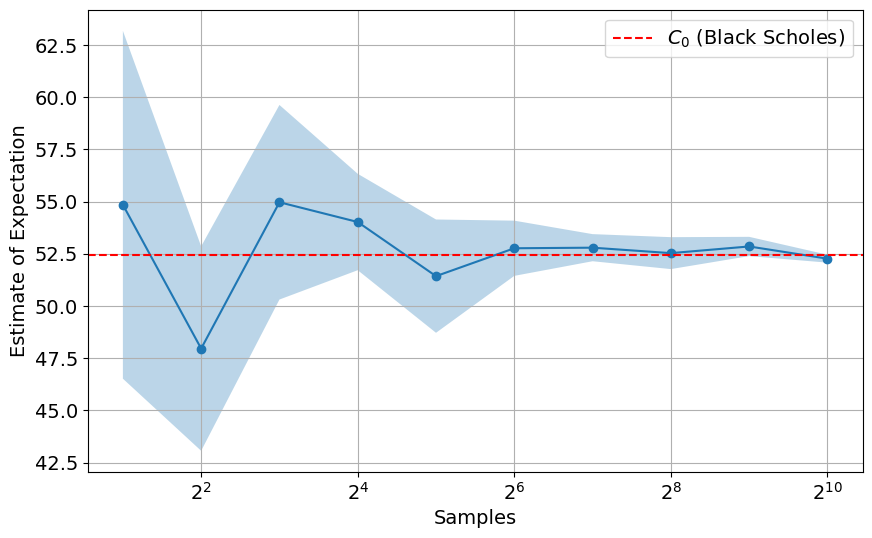

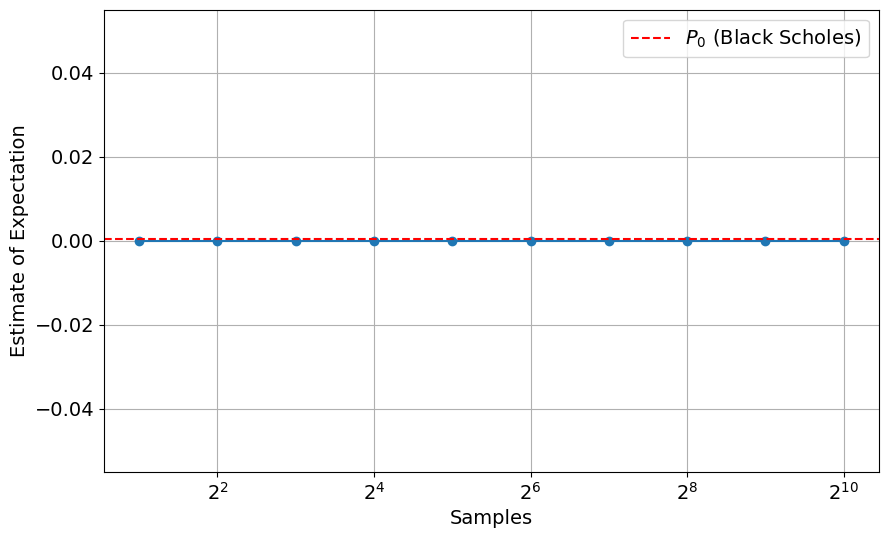

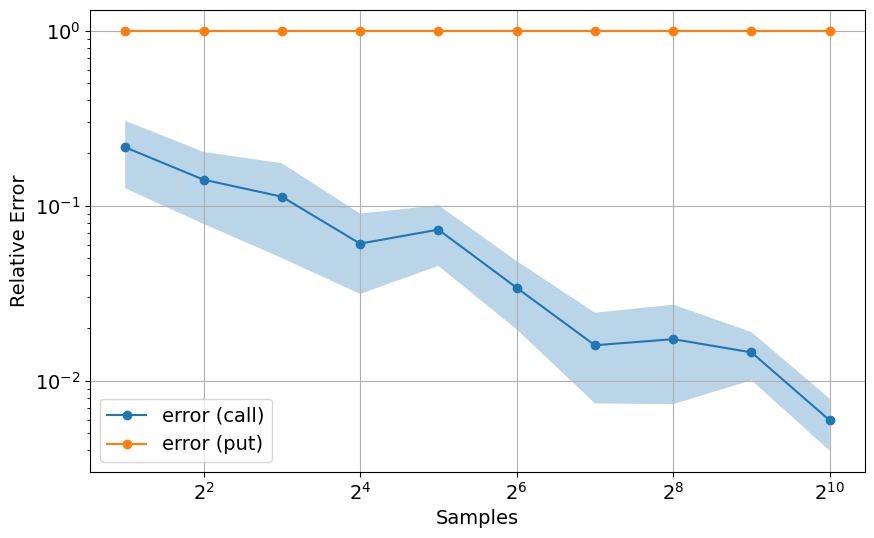

In [12]:
results_call = [results_standard_mc_call[i][0] for i in range(len(results_standard_mc_call))]
results_put = [results_standard_mc_put[i][0] for i in range(len(results_standard_mc_put))]
errors_call = [results_standard_mc_call[i][1] for i in range(len(results_standard_mc_call))]
errors_put = [results_standard_mc_put[i][1] for i in range(len(results_standard_mc_put))]

# plot results for call option
plt.figure(figsize=(10, 6))
x = [2**(i+1) for i in range(len(results_call[0]))]
y = average(results_call)
obs = len(results_call)
cfi = cf_interval(y, standard_deviation(results_call), obs)
plt.plot(x, y, marker='o', linestyle='-')
plt.fill_between(x, cfi[0], cfi[1], alpha=0.3)
plt.axhline(y=C_0, color='r', linestyle='--', label=r'$C_0$ (Black Scholes)')
plt.xscale('log', base=2)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Estimate of Expectation', fontsize=14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

# plot results for put option
plt.figure(figsize=(10, 6))
x = [2**(i+1) for i in range(len(results_put[0]))]
y = average(results_put)
obs = len(results_put)
cfi = cf_interval(y, standard_deviation(results_put), obs)
plt.plot(x, y, marker='o', linestyle='-')
plt.fill_between(x, cfi[0], cfi[1], alpha=0.3)
plt.axhline(y=P_0, color='r', linestyle='--', label=r'$P_0$ (Black Scholes)')
plt.xscale('log', base=2)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Estimate of Expectation', fontsize=14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

# plot results for call option
plt.figure(figsize=(10, 6))
x = [2**(i+1) for i in range(len(errors_call[0]))]
y = average(errors_call)
obs = len(errors_call)
cfi = cf_interval(y, standard_deviation(errors_call), obs)
plt.plot(x, y, marker='o', linestyle='-', label='error (call)')
plt.fill_between(x, cfi[0], cfi[1], alpha=0.3)

# plot results for put option
x = [2**(i+1) for i in range(len(errors_put[0]))]
y = average(errors_put)
obs = len(errors_put)
cfi = cf_interval(y, standard_deviation(errors_put), obs)
plt.plot(x, y, marker='o', linestyle='-', label='error (put)')
plt.fill_between(x, cfi[0], cfi[1], alpha=0.3)

plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Relative Error', fontsize=14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

Quantum Monte Carlo

In [13]:
# probability distribution loading
qc = NormalDistribution(n, mu=0, sigma=T, bounds=(-3*std, 3*std))
P = qc.to_gate(label='P')

In [18]:
# check if the correct superposition is created 
qr = QuantumRegister(n, name='q')
qc = QuantumCircuit(qr)
qc.append(P, [i for i in range(n)])
qc.measure_all(qr)

In [23]:
# run circuit
sampler = Sampler()
job = sampler.run(qc, shots=10**14, seed=42)
job_result = job.result()
counts = job_result.quasi_dists[0]

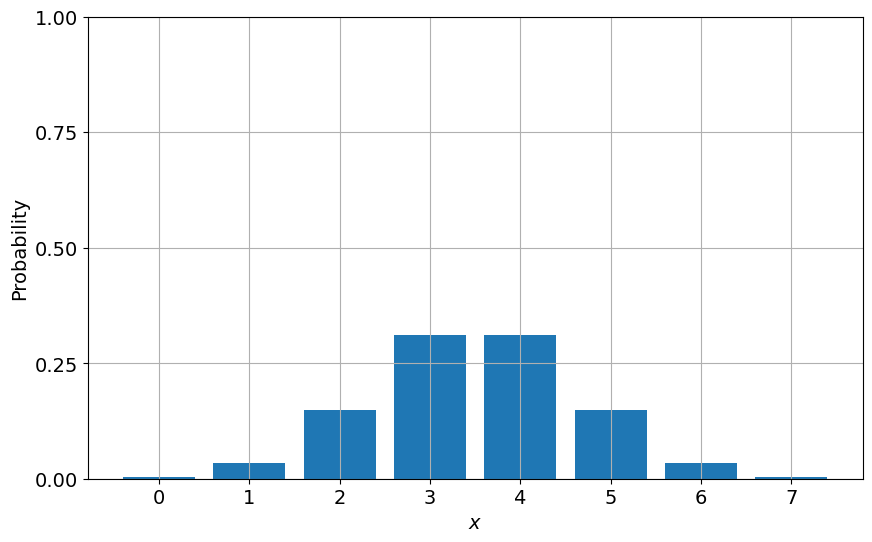

In [24]:
# plot results
gridpoints = list(counts.keys())
probabilities = list(counts.values())
plt.figure(figsize=(10, 6))
plt.bar(gridpoints, probabilities) 
plt.xticks(size=14)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=14)
plt.ylabel("Probability", size=14)
plt.xlabel(r"$x$", size=14)
plt.ylim((0, 1))
plt.grid()
plt.show()

In [14]:
# function to split the values into disjoiint intervals
def A_1(value, x):
    """
    Returns the value if it is less than x, otherwise return 0.
    """
    if value < x:
        res = value
    else:
        res = 0 
    return res

def A_2(value, x, y):
    """
    Returns the value if it is between x and y 
    (inclusive of x, exclusive of y), otherwise return 0.
    """
    if value >= x and value < y:
        res = value
    else:
        res = 0 
    return res

def A_3(value, y):
    """
    Returns the value if it is greater than or equal to y, 
    otherwise return 0.
    """ 
    if value >= y:
        res = value
    else:
        res = 0 
    return res

# function to apply controlled rotations as part of the state preperation
def state_function(state, value, qc):
    """
    Applies controlled rotations based on the state and value.

    Parameters:
    state (str): The bit string representing the state.
    value (float): The value for rotation.
    qc (QuantumCircuit): The quantum circuit.
    n (int): Number of qubits per time step.
    k (int): Number of time steps.
    """
    for i in range(len(state)):
        if state[i] == '0':
            qc.x([len(state)-i])
    
    # calculate the rotation angle
    theta = math.asin(value**0.5)*2    

    # create a controlled RY gate
    rot = RYGate(theta).control(len(state))

    # apply the controlled rotation 
    qc.append(rot, [i+1 for i in range(n)]+[0])
    
    for i in range(len(state)):
        if state[i] == '0':
            qc.x([len(state)-i]) 

# function to apply the phase oracle 
def V_operator(qc):
    """
    Applies the phase oracle (V operator) to the quantum circuit.

    Parameters:
    qc (QuantumCircuit): The quantum circuit.
    """
    qc.h([0])
    qc.x([0])
    qc.h([0])


# function to run amplitude estimation
def run_circuit(n, m, oracle, probability_model, output_values):
    
    """
    Runs the quantum circuit for amplitude estimation.

    Parameters:
    n (int): Number of qubits per time step.
    m (int): Number of evaluation qubits.
    probability_model (Gate): The gate representing the probability model.
    output_values (list): List of possible output_values values for v(x_i).

    Returns:
    float: The estimated amplitude.
    """  
       
    # generate bit strings
    bit_strings = [format(i, f'0{n}b') for i in range(2**n)]
    
    # create state preperation
    qr = QuantumRegister(n+1)
    state_prearation = QuantumCircuit(qr)

    # load probability distribution
    state_prearation.append(probability_model, [i+1 for i in range(n)])

    # apply state function
    for i, amplitude in enumerate(output_values):
        state_function(state=bit_strings[i], value=amplitude, qc=state_prearation)

    # create Grover operator
    Q = GroverOperator(oracle=oracle, 
                       state_preparation=state_prearation, 
                       zero_reflection=None, 
                       reflection_qubits=None, 
                       insert_barriers=False, 
                       mcx_mode='noancilla', 
                       name='Q')

    sampler = Sampler()
    ae = AmplitudeEstimation(
        num_eval_qubits=m, 
        sampler=sampler,
    )

    problem = EstimationProblem(
        state_preparation=state_prearation,  # A operator
        grover_operator=Q,  # Q operator
        objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )

    ae_result = ae.estimate(problem)
    
    return ae_result.estimation


def quantum_MC(n, m, probability_model, mapping, mean_proxy, parameters):

    """
    Runs the quantum Monte Carlo simulation.

    Parameters:
    n (int): Number of qubits
    m (int): Number of evaluation qubits.
    probability_model (Gate): The gate representing the probability model.
    mapping (dict): Mapping of bit strings to their corresponding payoffs.
    mean_proxy (float): Mean proxy for scaling.

    Returns:
    C0 (float): The estimated price of the option.
    """
    r = parameters['r']
    T = parameters['T']
    
    expectation = 0
    
    # scale values 
    output_values = [value/mean_proxy for value in mapping.values()]
    
    # max number of intervals 
    j = int(np.ceil(np.log2(max(output_values))))
    
    oracle = QuantumCircuit(QuantumRegister(n+1))
    V_operator(oracle)

    # run circuit for the first interval [0, 1)
    output_values_temp = []
    for value in output_values:
        output_values_temp.append(A_2(value, 0, 1))
    res = run_circuit(n, m, oracle, probability_model, output_values_temp)
    expectation += res

    # run circuit for subsequent intervals [2^i, 2^(i+1)) 
    for i in range(j):
        output_values_temp = []
        for value in output_values:
            output_values_temp.append(A_2(value, 2**i, 2**(i+1))/2**(i+1))
        res = run_circuit(n, m, oracle, probability_model, output_values_temp)
        expectation += res*2**(i+1)

    return math.exp(-r*T)*expectation*mean_proxy

Perform experiments with quantum Monte Carlo

In [15]:
iterations = 5
max_evaluation_qubits = 5
results_quantum_mc_call = []

for _ in range(iterations):
    results_quantum = []
    m_list = [i+1 for i in range(max_evaluation_qubits)]
    k = 32
    mean_proxy = np.mean(random.choices(list(mapping.values()), y_discretized, k=k))

    for m in m_list:
        res = quantum_MC(n, m, P, mapping, mean_proxy, parameters)
        results_quantum.append(res)
        print(m, res)

    errors_quantum = [abs(res-C_0)/C_0 for res in results_quantum]

    results_quantum_mc_call.append([results_quantum, errors_quantum])

1 0.0
2 81.82976337930663
3 81.82976337930663
4 50.514871308118074
5 52.61132802462568
1 0.0
2 78.17037797726823
3 78.17037797726823
4 48.2558719536421
5 50.25857619198559
1 0.0
2 79.16373905207922
3 79.16373905207922
4 48.86909023491676
5 50.89724411910062
1 0.0
2 75.19748733406497
3 39.749050909510835
4 54.05274096275999
5 53.049370862929926
1 0.0
2 68.23449111136044
3 68.23449111136044
4 49.04766639851951
5 53.314437362204


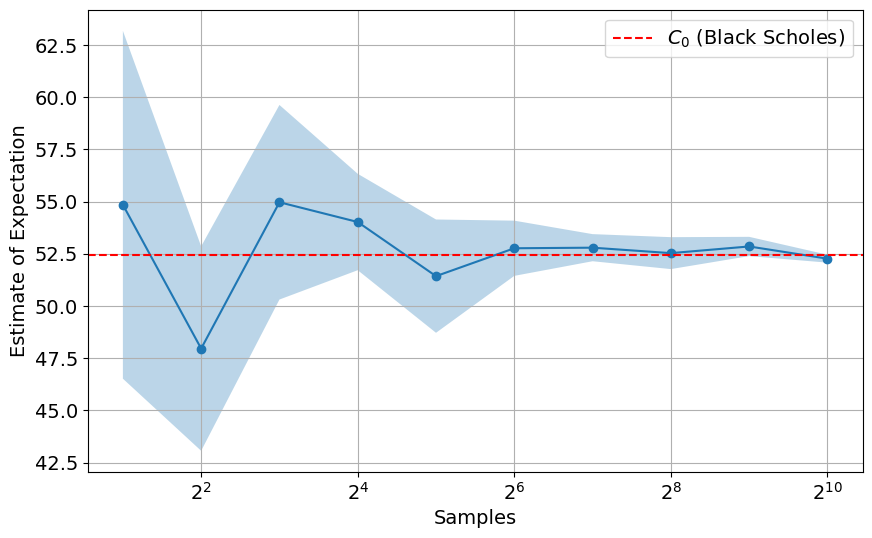

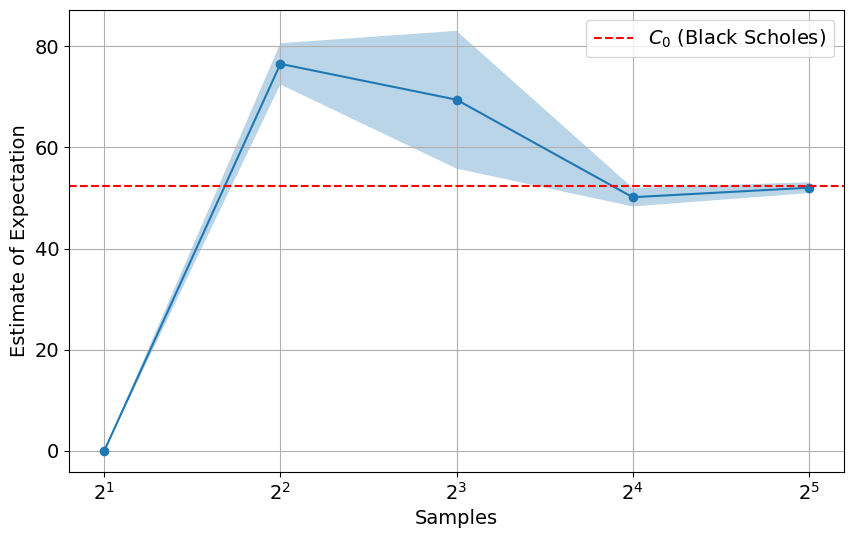

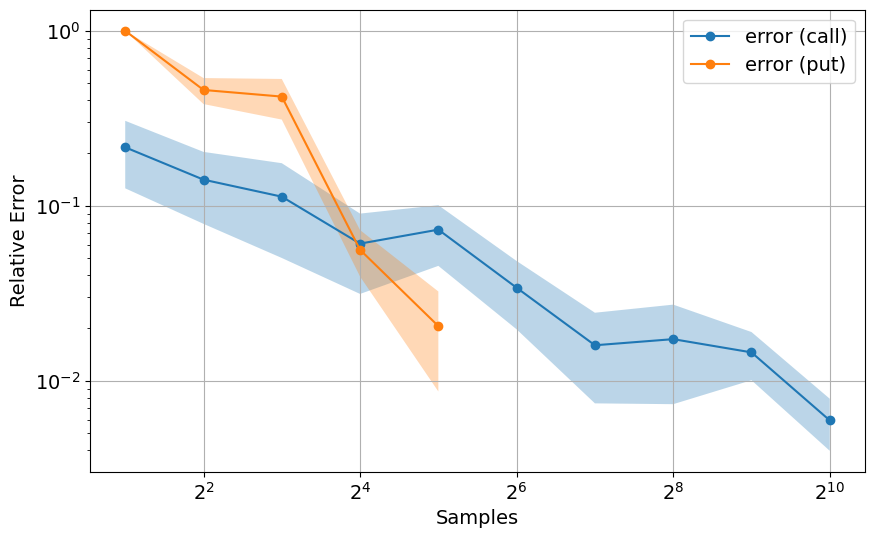

In [16]:
results_quantum = [results_quantum_mc_call[i][0] for i in range(len(results_quantum_mc_call))]
errors_quantum = [results_quantum_mc_call[i][1] for i in range(len(results_quantum_mc_call))]

# plot results for standard mc
plt.figure(figsize=(10, 6))
x = [2**(i+1) for i in range(len(results_call[0]))]
y = average(results_call)
obs = len(results_call)
cfi = cf_interval(y, standard_deviation(results_call), obs)
plt.plot(x, y, marker='o', linestyle='-')
plt.fill_between(x, cfi[0], cfi[1], alpha=0.3)
plt.axhline(y=C_0, color='r', linestyle='--', label=r'$C_0$ (Black Scholes)')
plt.xscale('log', base=2)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Estimate of Expectation', fontsize=14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

# plot results for quantum
plt.figure(figsize=(10, 6))
x = [2**(i+1) for i in range(len(results_quantum[0]))]
y = average(results_quantum)
obs = len(results_quantum)
cfi = cf_interval(y, standard_deviation(results_quantum), obs)
plt.plot(x, y, marker='o', linestyle='-')
plt.fill_between(x, cfi[0], cfi[1], alpha=0.3)
plt.axhline(y=C_0, color='r', linestyle='--', label=r'$C_0$ (Black Scholes)')
plt.xscale('log', base=2)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Estimate of Expectation', fontsize=14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

# plot results for standard mc
plt.figure(figsize=(10, 6))
x = [2**(i+1) for i in range(len(errors_call[0]))]
y = average(errors_call)
obs = len(errors_call)
cfi = cf_interval(y, standard_deviation(errors_call), obs)
plt.plot(x, y, marker='o', linestyle='-', label='error (call)')
plt.fill_between(x, cfi[0], cfi[1], alpha=0.3)

# plot results for quantum mc
x = [2**(i+1) for i in range(len(errors_quantum[0]))]
y = average(errors_quantum)
obs = len(errors_quantum)
cfi = cf_interval(y, standard_deviation(errors_quantum), obs)
plt.plot(x, y, marker='o', linestyle='-', label='error (put)')
plt.fill_between(x, cfi[0], cfi[1], alpha=0.3)

plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Relative Error', fontsize=14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

Check gate count

In [31]:
bit_strings = [format(i, f'0{n}b') for i in range(2**n)]
n = 3

# create state preperation
qr = QuantumRegister(n+1)
state_prearation = QuantumCircuit(qr)

# load probability distribution
state_prearation.append(P, [i+1 for i in range(n)])

print('Probability loading:')
print(state_prearation.decompose().depth())
print(state_prearation.decompose().count_ops())
print(state_prearation.decompose().size())


output_values = [value/mean_proxy for value in mapping.values()]
output_values = np.array(output_values)/4

# apply state function
for i, amplitude in enumerate(output_values):
    state_function(state=bit_strings[i], value=amplitude, qc=state_prearation)

print('')
print('Payoff function:')
print(state_prearation.depth())
print(state_prearation.count_ops())
print(state_prearation.size())

oracle = QuantumCircuit(QuantumRegister(n+1))
V_operator(oracle)

print('')
print('Oracle:')
print(oracle.depth())
print(oracle.count_ops())
print(oracle.size())

# # create Grover operator
Q = GroverOperator(oracle=oracle, 
                   state_preparation=state_prearation, 
                   zero_reflection=None, 
                   reflection_qubits=None, 
                   insert_barriers=False, 
                   mcx_mode='noancilla', 
                   name='Q')
print('')
print('Grover:')
print(Q.decompose().depth())
print(Q.decompose().count_ops())
print(Q.decompose().size())

Probability loading:
1
OrderedDict([('P(X)', 1)])
1

Payoff function:
21
OrderedDict([('x', 24), ('c3ry', 8), ('P(X)', 1)])
33

Oracle:
3
OrderedDict([('h', 2), ('x', 1)])
3

Grover:
50
OrderedDict([('x', 57), ('c3ry', 16), ('h', 4), ('P(X)_dg', 1), ('mcx', 1), ('P(X)', 1)])
80
